In [ ]:
!pip install nilearn

## Training

For each voxel, we will produce a set of 339 (number of categories in our dataste) model weights reflecting how each object and action category
influences BOLD responses in each voxel.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV
import nilearn
import nibabel as ni
import sklearn
import scipy

from sklearn.linear_model import Ridge
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.feature_selection import r_regression

from nilearn import image


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "drive/Shareddrives/WHMS_Huth_Replication/"

[Errno 2] No such file or directory: 'drive/Shareddrives/WHMS_Huth_Replication/'
/content/drive/Shareddrives/WHMS_Huth_Replication


Steps will be :

```
1. Read the corresponding stimuli (X) and neural data (Y).
2. Obtain subsets of train (X_train, y_train) and test sets (X_test, y_test).
3. Fit a machine learning model on the train set (X_train, y_train).

    3a. Use Cross-Validation for zero-shot learning.
                            OR,
    3a. Use Nested Cross-Validation when train and test sets contain multiple samples for the same stimulus.

    Optional: Do PCA.


    3b. Obtain predictions on the test set (X_test, y_test).

4. Evaluate the predictions using a scoring metric (E.g., 2 vs 2 test, Correlation).
5. Calculate statistical significance of the results.
    5a. Run many iterations of the permutation test i.e., a resampling procedure.
    5b. Calculate how many times the permuted accuracy is as extreme as the observed accuracy
    -> This gives you the p-value.
    5c. Correct for multiple comparisons.
```

# Step 1: Reading data

In [ ]:
category_stimulus_matrix = pd.read_csv("Embeddings/contextual_fluid_CL_3.csv")
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

category_stimulus_matrix.pop("Unnamed: 0")
category_stimulus_matrix.shape
# category_stimulus_matrix["28"]

(210, 768)

In [ ]:
category_stimulus_matrix

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.665466,-0.481045,-0.632538,-0.574211,0.265978,0.208252,-0.110487,0.617048,-0.358210,-0.346418,...,0.426505,-0.362684,0.342742,0.244411,0.221504,0.036397,0.041988,0.079929,0.351689,-0.085440
1,-0.657635,-0.516807,-0.571140,-0.521586,0.317902,0.121576,-0.247897,0.684638,-0.384625,-0.642871,...,0.420287,-0.456432,0.223256,0.229224,0.272600,-0.080696,0.056312,0.108017,0.399184,-0.046890
2,-0.561190,-0.534332,-0.265085,-0.541395,0.160462,0.063830,-0.152606,0.592112,-0.429408,-0.643014,...,0.331615,-0.297201,0.290333,0.339877,0.053910,-0.070756,0.329703,-0.081345,0.217889,-0.292074
3,0.171892,-0.600783,0.122656,-0.435181,-0.095137,-0.036851,0.367848,0.987378,-0.291586,-0.798707,...,0.001379,-0.197004,0.065439,0.465560,0.538177,0.200813,0.451836,-0.410598,0.259384,-0.089665
4,-0.372786,-0.751238,0.138237,-0.394368,-0.081964,-0.186508,-0.156211,0.578065,-0.235884,-0.355177,...,-0.248846,-0.236079,-0.028546,0.444701,0.135795,0.010700,0.193112,-0.515183,0.012225,0.031256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,-0.579371,-0.571055,-0.274274,-0.291414,-0.225291,-0.175361,-0.104382,0.623696,-0.161913,-0.836634,...,-0.009626,0.135946,-0.033877,0.336517,-0.465816,0.573888,-0.308555,-0.145637,-0.278781,0.064999
206,-0.680357,-0.669745,-0.004662,-0.347313,-0.154219,-0.134749,0.293586,0.629692,-0.091549,-0.548687,...,0.038114,-0.280570,0.268845,0.304825,0.196548,0.121319,0.300779,-0.091723,0.279103,-0.251078
207,-0.080315,-0.701456,0.061144,-0.366875,0.317423,0.131670,0.414080,0.783039,-0.001678,-0.953485,...,-0.199780,-0.227290,0.182268,0.054442,-0.036628,0.177856,0.296262,0.244555,-0.253393,-0.177136
208,-0.223408,-0.771718,-0.055554,-0.595071,0.294501,0.488388,0.129721,0.452024,-0.263728,-0.897276,...,0.242191,-0.693873,-0.536418,-0.125724,0.277231,0.137685,0.287937,-0.134624,-0.054463,0.334956


In [ ]:
category_stimulus_matrix.shape

(210, 768)

In [ ]:
img = ni.load('Processed-fMRI/Group1/P1001-G1/filtered_func_data.nii.gz')
S1 = img.get_data() # subject 1

<ipython-input-47-ba4c5c55560a>:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  S1 = img.get_data() # subject 1


In [ ]:
inactive_count = 0
for i in range(80):
    for j in range(80):
        for k in range(40):
            if np.array_equal(S1[i,j,k,:], np.zeros(210)):
                inactive_count += 1
inactive_count

185335

In [ ]:
del nilearn
del ni

In [ ]:
S1_voxel_volume = np.zeros((len(S1[:,0,0,0]) * len(S1[0,:,0,0]) * len(S1[0,0,:,0]), 210)) # volumes of flatten voxels
voxel_num = 0
for i in range(len(S1[:,0,0,0])):
    for j in range(len(S1[0,:,0,0])):
         for k in range(len(S1[0,0,:,0])):
             S1_voxel_volume[voxel_num] = S1[i,j,k,:]
             voxel_num += 1
del S1, img

In [ ]:
S1_voxel_volume = np.transpose(S1_voxel_volume)
print(S1_voxel_volume.shape)

(210, 256000)


In [ ]:
print("Shape of the fMRI data: ", S1_voxel_volume.shape)
print("Shape of the category data: ", category_stimulus_matrix.shape)

Shape of the fMRI data:  (210, 256000)
Shape of the category data:  (210, 768)


Since dimensions of the rows of both sets doesn't match, I will cut half of the category stimulus matrix to make it equal to the number of volumes.

In [ ]:
Y = S1_voxel_volume
del S1_voxel_volume

In [ ]:
Y.shape

(210, 256000)

Creating the design matrix

In [ ]:
motion_energy = pd.read_csv("Training/motion_energy_regressor.csv")
motion_energy = motion_energy.drop("Unnamed: 0", axis=1)
motion_energy = np.array(motion_energy)

In [ ]:
category_stimulus_matrix = np.array(category_stimulus_matrix)

In [ ]:
from scipy.ndimage.interpolation import shift
X = category_stimulus_matrix.copy()
delayed_category_stimulus_matrix = []
print(X)
for col_i in range(X.shape[1]): # for each category
    tr1 = shift(X[:,col_i], 1, cval=0)
    tr2 = shift(X[:,col_i], 2, cval=0)
    tr3 = shift(X[:,col_i], 3, cval=0)
    tr4 = shift(X[:,col_i], 4, cval=0)
    delayed_category_stimulus_matrix.append(tr1)
    delayed_category_stimulus_matrix.append(tr2)
    delayed_category_stimulus_matrix.append(tr3)
    delayed_category_stimulus_matrix.append(tr4)

delayed_category_stimulus_matrix= np.transpose(np.array(delayed_category_stimulus_matrix))

[[-0.6654657  -0.48104477 -0.6325384  ...  0.07992914  0.35168907
  -0.08543956]
 [-0.6576351  -0.5168072  -0.5711402  ...  0.10801704  0.39918396
  -0.04689047]
 [-0.56118995 -0.53433156 -0.26508498 ... -0.08134455  0.21788931
  -0.292074  ]
 ...
 [-0.08031505 -0.70145637  0.0611441  ...  0.2445546  -0.25339267
  -0.1771362 ]
 [-0.22340818 -0.771718   -0.05555449 ... -0.13462426 -0.05446305
   0.33495638]
 [-0.48389828 -0.47938383 -0.15722544 ... -0.6288793  -0.36482796
   0.6848006 ]]


<ipython-input-57-fdbf11d31c38>:1: DeprecationWarning: Please use `shift` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import shift


In [ ]:
pd.DataFrame(delayed_category_stimulus_matrix).head

<bound method NDFrame.head of          0         1         2         3         4         5         6     \
0    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1   -0.665466  0.000000  0.000000  0.000000 -0.481045  0.000000  0.000000   
2   -0.657635 -0.665466  0.000000  0.000000 -0.516807 -0.481045  0.000000   
3   -0.561190 -0.657635 -0.665466  0.000000 -0.534332 -0.516807 -0.481045   
4    0.171892 -0.561190 -0.657635 -0.665466 -0.600783 -0.534332 -0.516807   
..        ...       ...       ...       ...       ...       ...       ...   
205 -0.280553 -0.555010 -0.477663  0.100948 -0.391741 -0.522760 -0.647146   
206 -0.579371 -0.280553 -0.555010 -0.477663 -0.571055 -0.391741 -0.522760   
207 -0.680357 -0.579371 -0.280553 -0.555010 -0.669746 -0.571055 -0.391741   
208 -0.080315 -0.680357 -0.579371 -0.280553 -0.701456 -0.669746 -0.571055   
209 -0.223408 -0.080315 -0.680357 -0.579371 -0.771718 -0.701456 -0.669746   

         7         8         9     ...      3

In [ ]:
design_matrix = delayed_category_stimulus_matrix

In [ ]:
# design_matrix = pd.read_csv("Training/FIR_design_matrix.csv")
# design_matrix.drop(["Unnamed: 0"], axis=1, inplace=True)

with open('Processed-fMRI/Group1/P1001-G1/1001_prefiltered_func_data_mcf.par','r') as f:
	listl=[]
	for line in f:
		strip_lines=line.strip()
		listli=strip_lines.split()
		m=listl.append(listli)


parameters = np.array(listl)

# parameters[:,0].shape

# design_matrix["tx = parameters[:,0].astype(np.float64)
design_matrix = np.column_stack((design_matrix, parameters[:,0].astype(np.float64)))
design_matrix = np.column_stack((design_matrix, parameters[:,1].astype(np.float64)))
design_matrix = np.column_stack((design_matrix, parameters[:,2].astype(np.float64)))
design_matrix = np.column_stack((design_matrix, parameters[:,3].astype(np.float64)))
design_matrix = np.column_stack((design_matrix, parameters[:,4].astype(np.float64)))
design_matrix = np.column_stack((design_matrix, parameters[:,5].astype(np.float64)))
design_matrix = np.column_stack((design_matrix, motion_energy))

# Do drift and constant

design_matrix.shape

(210, 3079)

In [ ]:
design_matrix_df = design_matrix.copy()

In [ ]:
print(type(design_matrix))

<class 'numpy.ndarray'>


S1_voxel_volume has each volume as rows and each voxel as columns for subject 1. We will use that to train the model.

# Model training (nested monte carlo cv)



First, I will group similar stimuli and they will go to the same set (either train or test)

In [ ]:
# IF IT'S EXACTLY THE SAME

volumes_seen = [] # indices
groups = [] # [[vol1, vol2], [vol3, vol4]] if first three volumes are very similar. If they are similar to the first volume

print(category_stimulus_matrix.shape)
for vol_i in range(category_stimulus_matrix.shape[0]):
    # for every volume in matrix
    for vol2_i in range(vol_i, category_stimulus_matrix.shape[0]):
        # for every other volume
        if vol_i != vol2_i:
            if np.array_equal(category_stimulus_matrix[vol_i, :], category_stimulus_matrix[vol2_i, :]):
                groups.append([vol_i, vol2_i])

    volumes_seen.append(vol_i)

groups

(210, 768)


[[149, 150]]

In [ ]:
new_groups = {} # key is the first element encountered and followed with array that has similar stimuli to that

for group in reversed(groups):
    key_found, value_found = False, False
    found_key = None # correct key if the value was found

    for key, values in new_groups.items():
        # checks if the element was already in the dictionary
        if group[0] == key:
            key_found = True
            break

    if key_found == False and value_found == False:
        new_groups[group[0]] = [group[0], group[1]]
    elif value_found == True:
        new_groups[found_key].append(group[1])
    elif key_found == True:
        new_groups[group[0]].append(group[1])


keys, keys_and_values = [], []
for key, value in new_groups.items():
    keys.append(key)
    keys_and_values.append([key, value])

for key in keys:
    for key2, values in keys_and_values:
        for value in values:
            if key != key2 and key == value:
                new_groups.pop(key, None)


final_groups = list(new_groups.values())

for i in range(210):
    if not any(i in x for x in final_groups):
        final_groups.append([i])


Pieces of code below were for only finding the SAME stimuli

In [ ]:
import random
def custom_train_test_split():
    # This takes account of the same stimuli and groups them together
    train_idx = []
    test_idx = []
    val_idx = []

    for group in final_groups:
        rand_num = random.random()
        if rand_num < 0.10:
            for index in group:
                test_idx.append(index)
        # elif rand_num >= 0.10 and rand_num < 0.15:
          #   for index in group:
            #    val_idx.append(index)
        else:
            for index in group:
                train_idx.append(index)

    for i in test_idx:
        if i in train_idx:
            test_idx.remove(i)

    #for i in val_idx:
     #   if i in train_idx:
      #      train_idx.remove(i)

    #for i in val_idx:
     #   if i in test_idx:
      #      val_idx.remove(i)


    return np.array(train_idx), np.array(test_idx)


train_idx, test_idx = custom_train_test_split()


print(train_idx)
print(test_idx)

print(len(train_idx), len(test_idx))

for i in range(210):
    if i not in train_idx and i not in test_idx:
        print(i, " is not in there")

dict_ = {}
for i in train_idx:
    if i in dict_.keys():
        dict_[i] += 1
    else:
        dict_[i] = 1

for i in test_idx:
    if i in dict_.keys():
        dict_[i] += 1
    else:
        dict_[i] = 1
dict_

for i in range(210):
    if i not in dict_.keys():
        print(i, "i not in there")


[  0   1   2   3   4   6   7   8   9  10  11  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  29  30  31  32  33  34  35  36  37  38
  39  41  42  43  44  45  46  47  48  49  53  54  55  56  57  58  59  60
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  80  82  83  84  85  87  88  89  90  91  92  93  94  95  97  98  99 100
 101 102 104 105 108 109 110 112 113 114 115 116 117 118 119 120 121 122
 123 124 126 127 128 129 130 131 132 133 136 137 140 141 142 144 145 146
 147 148 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166
 167 168 169 170 171 172 173 176 177 178 179 180 182 183 184 185 186 187
 188 190 191 192 196 198 199 202 203 204 205 206 207 208 209]
[149 150   5  12  28  40  50  51  52  79  81  86  96 103 106 107 111 125
 134 135 138 139 143 174 175 181 189 193 194 195 197 200 201]
177 33


In [ ]:
import random
import math
def train_test_split_by_time(X):
    train_idx = []
    test_idx = []

    # divide into timestamps
    n_splits = 5
    TR_divided_into_timestamps = []
    print(X.shape[0])
    curr_timestamps = []
    for i in range(X.shape[0]):
        if i != 0 and i % n_splits == 0:
            TR_divided_into_timestamps.append(curr_timestamps)
            curr_timestamps = [i]
        else:
            curr_timestamps.append(i)
    # TR_divided_into_timestamps.append([X.shape[0]-3, X.shape[0]-2, X.shape[0]-1])
    TR_divided_into_timestamps.append([X.shape[0]-5, X.shape[0]-4, X.shape[0]-3, X.shape[0]-2, X.shape[0]-1])

    # I will split 90% train and 10% test
    n_timestamps = len(TR_divided_into_timestamps) # 210 / n_splits
    # 7 of them are going to test set.
    test_timestamps_idx = set()
    while len(test_timestamps_idx) != math.floor(len(TR_divided_into_timestamps)/10):
        test_timestamps_idx.add(random.randrange(len(TR_divided_into_timestamps)))

    test_timestamps_idx = list(test_timestamps_idx)
    for i in range(len(TR_divided_into_timestamps)): # 70
        if i not in test_timestamps_idx:
            for j in range(n_splits):
                train_idx.append(TR_divided_into_timestamps[i][j])
        else:
            for j in range(n_splits):
                test_idx.append(TR_divided_into_timestamps[i][j])


    return np.array(train_idx), np.array(test_idx)


train_idx, test_idx = train_test_split_by_time(X)

print(train_idx)
print(test_idx)

print(len(train_idx), len(test_idx))

for i in range(210):
    if i not in train_idx and i not in test_idx:
        print(i, " is not in there")

dict_ = {}
for i in train_idx:
    if i in dict_.keys():
        dict_[i] += 1
    else:
        dict_[i] = 1

for i in test_idx:
    if i in dict_.keys():
        dict_[i] += 1
    else:
        dict_[i] = 1
dict_

for i in range(210):
    if i not in dict_.keys():
        print(i, "i not in there")

210
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  75  76
  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 122 123 124 130 131 132 133 134 135
 136 137 138 139 145 146 147 148 149 150 151 152 153 154 155 156 157 158
 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176
 177 178 179 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209]
[ 70  71  72  73  74 125 126 127 128 129 140 141 142 143 144 180 181 182
 183 184]
190 20


In [ ]:
import random

Posterior is proportional to (likelihood * prior). The likelihood we are calculating below is actually the posterior (figure S2 of Nishimoto 2011 supplemental)

How to use correlation coefficients we gathered across samples to get a single correlation coefficient. https://www.statology.org/fisher-z-transformation/

In [ ]:
# Y is (210, 256000)
active_voxel_indeces = [] # indeces of the voxel that have at least one activation during 210 volumes.
for voxel_i in range(256000):
    active = False
    for vol in range(210):
        if Y[vol, voxel_i] != 0:
            active = True
            break
    if active:
        active_voxel_indeces.append(voxel_i)

len(active_voxel_indeces)

Y = Y[:, active_voxel_indeces]

In [ ]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# design_matrix = scaler.fit_transform(design_matrix)

In [ ]:
print(design_matrix.shape)

(210, 3079)


In [ ]:
a = "CL{}".format(2)
a

'CL2'

In [ ]:
print(X.shape)

(210, 768)


Running PCA on X to match the number of features with word2vec

In [ ]:
"""
# PCA to make X 300 dimensional
print(X.shape)
from sklearn.decomposition import PCA
pca = PCA(n_components=30)
X = pca.fit_transform(X)

print(X.shape)
"""

'\n# PCA to make X 300 dimensional\nprint(X.shape)\nfrom sklearn.decomposition import PCA\npca = PCA(n_components=30)\nX = pca.fit_transform(X)\n\nprint(X.shape)\n'

In [ ]:
print(pd.DataFrame(design_matrix))

         0         1         2         3         4         5         6     \
0    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1   -0.665466  0.000000  0.000000  0.000000 -0.481045  0.000000  0.000000   
2   -0.657635 -0.665466  0.000000  0.000000 -0.516807 -0.481045  0.000000   
3   -0.561190 -0.657635 -0.665466  0.000000 -0.534332 -0.516807 -0.481045   
4    0.171892 -0.561190 -0.657635 -0.665466 -0.600783 -0.534332 -0.516807   
..        ...       ...       ...       ...       ...       ...       ...   
205 -0.280553 -0.555010 -0.477663  0.100948 -0.391741 -0.522760 -0.647146   
206 -0.579371 -0.280553 -0.555010 -0.477663 -0.571055 -0.391741 -0.522760   
207 -0.680357 -0.579371 -0.280553 -0.555010 -0.669746 -0.571055 -0.391741   
208 -0.080315 -0.680357 -0.579371 -0.280553 -0.701456 -0.669746 -0.571055   
209 -0.223408 -0.080315 -0.680357 -0.579371 -0.771718 -0.701456 -0.669746   

         7         8         9     ...      3069      3070      3071  \
0  

Actual model training

In [ ]:
len(test_idx)

20

In [ ]:
test_idx[0]

70

In [ ]:
dict_all_preds = {} # {TR0 : [appending total r^2 calculated on correlation of all voxel's correlation]}
for i in range(210):
    dict_all_preds[i] = []



In [ ]:
# cv = KFold(n_splits=10, shuffle=True, random_state=1)
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import sys
np.set_printoptions(threshold=sys.maxsize)

n_active_voxel = len(active_voxel_indeces)
R2_scores_design = [] # R2 scores
# r_scores_design = np.zeros((10, 256000)) # pearson's correlation coefficient r scores. 10 is the number of folds and 256000 is the number of voxels
r_scores_sum = np.zeros(n_active_voxel)
p_values_design = np.zeros((10, n_active_voxel)) # p values of the pearson's correlation coefficient test
r2_scores = np.zeros(10)
alphas = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1, 5, 10]
alphas_dict = {"alpha":alphas}
weights_sum = np.zeros((n_active_voxel, design_matrix.shape[1]))


iterations = 3
fold_num = 0

correct_identification = 0
incorrect_identification = 0

got_neg_example = False
got_pos_example = False
random.seed(100)
# for train, test in cv.split(X=design_matrix):
for iter in range(iterations):

    train_idx, test_idx = train_test_split_by_time(X)
    print(test_idx)
    # create a ridge model
    # model = RidgeCV(alphas=alphas, cv=5)
    # model = RidgeCV(alphas=alphas, alpha_per_target=True)
    estimator = Ridge(solver='svd')
    model = GridSearchCV(estimator, alphas_dict, n_jobs=-1, cv=5, scoring='neg_mean_squared_error')

    # X_train, X_test, y_train, y_test = train_test_split(design_matrix, Y, test_size=0.3)  # This is a custom function.


    X_train = design_matrix[train_idx,:]
    y_train = Y[train_idx,:]
    X_test = design_matrix[test_idx,:]
    y_test = Y[test_idx,:]

    # Normalize Xs
    #scaler = StandardScaler()
    #X_train = scaler.fit_transform(X_train)
    #X_test = scaler.transform(X_test)

    # Normalize Ys
    scaler = StandardScaler()
    y_train = scaler.fit_transform(y_train)
    y_test = scaler.transform(y_test)

    # category_stimulus_matrix = StandardScaler().fit_transform(category_stimulus_matrix)

    # train the Ridge model on the training set
    # model_design.fit(design_matrix[train], Y[train]) # fitting model without hemodynamic delay
    model.fit(X_train, y_train) # fitting model without hemodynamic delay

    # print(model.best_estimator_.coef_.shape)

    # and predict the fMRI activity for the test set

    # remove motion parameters

    without_motion = X_test.copy()
    without_motion[:,-1] = 0

    predictions_design = model.predict(without_motion)
    print(predictions_design.shape)

    for j in range(len(test_idx)):
        pearson_r, p_value = scipy.stats.pearsonr(y_test[j,:], predictions_design[j,:])
        if np.isnan(pearson_r):
            pearson_r = 0
        dict_all_preds[j] = pearson_r


    significant_voxel_indices = []

    for i in range(n_active_voxel): # for each voxel
        pearson_r, p_value = scipy.stats.pearsonr(y_test[:,i], predictions_design[:,i])
        if np.isnan(pearson_r):
            pearson_r = 0

        # r_scores_design[iter, i] = z
        r_scores_sum[i] += pearson_r
        # p_values_design[iter, i] = p_value


        ## GET A negative EXAMPLE FOR VISUALIZATION

        if p_value < 0.05 and pearson_r < 0 and got_neg_example == False:
            example_neg_prediction = predictions_design[:, i]
            example_neg_true = y_test[:, i]
            example_neg_r = pearson_r
            got_neg_example = True

        if p_value < 0.05 and pearson_r > 0:
            significant_voxel_indices.append(i)

        if p_value < 0.05 and pearson_r > 0 and got_pos_example == False:
            example__pos_prediction = predictions_design[:, i]
            example_pos_true = y_test[:, i]
            example_pos_r = pearson_r
            got_pos_example = True
            # print("YES", pearson_r)
        # else:
            # print("NO", pearson_r)

    print(len(significant_voxel_indices))


    # To get the r squared score, we want to extract the voxels that have no activation

    r2_scores[iter] = r2_score(y_test[:, significant_voxel_indices], predictions_design[:, significant_voxel_indices])

    # print(model.coef_.shape)
    weights_sum += model.best_estimator_.coef_
    # weights_sum += model.coef_
    # weights38.append(model.best_estimator_.coef_[38000, :])
    del model

# Getting the average weights
weights_averaged = weights_sum / iterations
r_scores_averaged = r_scores_sum / iterations

del X_train
del y_train
del X_test
del y_test
del without_motion

210
[ 45  46  47  48  49  55  56  57  58  59 125 126 127 128 129 145 146 147
 148 149]
(20, 70665)
2948
210
[ 35  36  37  38  39 110 111 112 113 114 135 136 137 138 139 160 161 162
 163 164]
(20, 70665)
5594
210
[ 25  26  27  28  29  35  36  37  38  39 145 146 147 148 149 170 171 172
 173 174]
(20, 70665)
4138


Looking at which stimuli has best prediction rates

In [ ]:
avg_correlation_per_TR = []

for key, value in dict_all_preds.items():
    avg_correlation_per_TR.append(np.mean(value))

best_TR_indices = sorted(range(len(avg_correlation_per_TR)), key = lambda sub: avg_correlation_per_TR[sub])[-15:]
worst_TR_indices = sorted(range(len(avg_correlation_per_TR)), key = lambda sub: avg_correlation_per_TR[sub])[:15]


In [ ]:
avg_correlation_per_TR

[-0.1504812183271551,
 -0.09588041555181363,
 -1.5690846757995813e-05,
 -0.007494796283866397,
 0.10654194569157002,
 0.0548007409126024,
 -0.0449261999077038,
 0.031761742480520286,
 0.16386510206719904,
 0.132989844870391,
 0.07009867862011328,
 0.08576268158452875,
 -0.027183381727924307,
 -0.02581485668309498,
 0.0801426684469964,
 0.3074523847478177,
 0.06759126644214071,
 -0.017508473978867324,
 0.06688811677667066,
 -0.05299953612568363,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,

In [ ]:
print(best_TR_indices)
print(worst_TR_indices)

[195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209]
[0, 1, 19, 6, 12, 13, 17, 3, 2, 7, 5, 18, 16, 10, 14]


In [ ]:
r2_scores

array([ 0.03818135, -0.05760122,  0.08442854,  0.08061377,  0.09016463,
        0.11964179, -0.01613002,  0.06460916, -0.11586578, -0.27035515])

In [ ]:
### Huth's metric sum of r_sv = r_sv * abs(r_sv) for all voxels
huth_r2 = r_scores_averaged * abs(r_scores_averaged)
print(huth_r2.shape)
huth_r2_sum = np.sum(huth_r2)
print(huth_r2_sum)

(70665,)
773.931028048738


In [ ]:
# weights38 = np.array(weights38)

In [ ]:
# print(weights38[0,:])

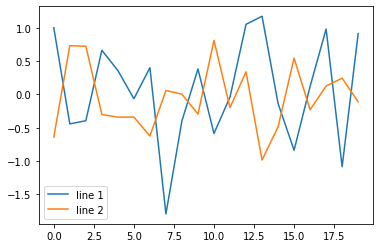

In [ ]:
x_axis = [i for i in range(example_neg_prediction.shape[0])]
plt.plot(x_axis, example_neg_true, label = "line 1")
plt.plot(x_axis, example_neg_prediction, label = "line 2")
plt.legend()
plt.show()

In [ ]:
print(example_neg_r)

-0.517065123195274


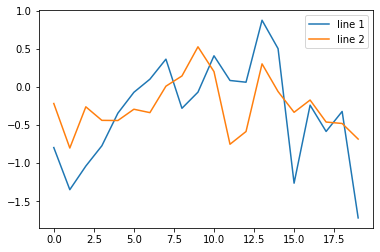

In [ ]:
x_axis = [i for i in range(example__pos_prediction.shape[0])]
plt.plot(x_axis, example_pos_true, label = "line 1")
plt.plot(x_axis, example__pos_prediction, label = "line 2")
plt.legend()
plt.show()

In [ ]:
print(example_pos_r)

0.558101160123543


In [ ]:
# combining p-values with Fisher's method https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.stats.combine_pvalues.html
combined_pvalues = []

from scipy.stats import combine_pvalues
for i in range(n_active_voxel):
    combined_pvalue = combine_pvalues(list(p_values_design[:,i]))
    combined_pvalues.append(combined_pvalue[1])

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:8203: RuntimeWarning: divide by zero encountered in log
  statistic = -2 * np.sum(np.log(pvalues))


In [ ]:
significantly_predicted = 0
significant_voxels = []
average_r_value = 0

for i in range(n_active_voxel):
    if combined_pvalues[i] <= 0.05 and r_scores_averaged[i] > 0.25:
        significant_voxels.append(i)
        significantly_predicted += 1
        average_r_value += r_scores_averaged[i]
average_r_value = average_r_value / significantly_predicted

print(average_r_value)
print(significantly_predicted)


0.3207545687844353
3951


In [ ]:
combined_pvalues = np.array(combined_pvalues)
# print(r_scores_averaged.shape)
print(combined_pvalues.shape)
print(weights_averaged.shape)
S1_weights = weights_averaged

(70665,)
(70665, 3079)


In [ ]:
label_weights_dict = {} # keys as design matrix label names (L0 to constant) and values as the 256000 dimensional vector that represent weights for each voxel

for i in range(len(design_matrix_df.columns)):
    label_weights_dict[design_matrix_df.columns[i]] = S1_weights[:,i]

del S1_weights

S1_category_weights = [] # should have the size (256000, 339)

for cat_i in range(339):
    weight_sum = label_weights_dict["L"+str(cat_i)+"_delay_1"] + label_weights_dict["L"+str(cat_i)+"_delay_2"] + label_weights_dict["L"+str(cat_i)+"_delay_3"] + label_weights_dict["L"+str(cat_i)+"_delay_4"]
    S1_category_weights.append(weight_sum / 4)

S1_category_weights = np.transpose(np.array(S1_category_weights))

# from sklearn.preprocessing import StandardScaler
# category_stimulus_matrix = StandardScaler().fit_transform(category_stimulus_matrix)

AttributeError: ignored

In [ ]:
S1_significant = StandardScaler().fit_transform(S1_category_weights[significant_voxels])
del S1_category_weights

In [ ]:
from sklearn.decomposition import PCA
S1_pca_weights = PCA(n_components=20) # gets the most significant 20 PCs.
S1_PC_weights = S1_pca_weights.fit_transform(S1_significant)

S1_self_variance_explained = S1_pca_weights.explained_variance_ratio_
S1_self_variance_explained

In [ ]:
pd.DataFrame(significant_voxels).to_csv('Training/Group1/P1001-G1/1001_significant_index.csv', encoding='utf-8-sig')

In [ ]:
pd.DataFrame(r_scores_averaged).to_csv('Training/Group1/P1001-G1/1001_r_scores.csv', encoding='utf-8-sig')
pd.DataFrame(combined_pvalues).to_csv('Training/Group1/P1001-G1/1001_p_values.csv', encoding='utf-8-sig')

In [ ]:
pd.DataFrame(weights_averaged).to_csv('Training/Group1/P1001-G1/1001_weights_FIR.csv', encoding='utf-8-sig')